<a href="https://colab.research.google.com/github/EliTirman/Pra3024_2023/blob/main/gw_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
# IMPORTS
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.filter import highpass, match
from pycbc.waveform import get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
from pycbc.psd import welch
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries
from scipy import interpolate
import numpy as np
from pycbc import frame
import pycbc
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d
from pycbc import types 
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.waveform import get_td_waveform
import pycbc.psd
from pycbc.psd import interpolate, aLIGOZeroDetHighPower

Assignment 1 Matched filter

- Download the data set from [1]. This data set contains a noise time series and an additional gravitational wave signal, where the sampling rate of the time series is 16384Hz. The first column of the data set refers to the time. The second and third columns are the data recorded by LIGO Hanford and Livingston, respectively. For the sake of convenience in data analysis, we downsample the data at a sampling rate of 2048Hz.


In [21]:
# We start by loading the data, converting it to time series, defining strain and stilde arrays that contain the data from two detectors

d = np.load('//content/drive/MyDrive/Colab Notebooks/GW_noisedata-2.npy') 
dt = d[:, 0]
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0], epoch=dt[0])
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0], epoch=dt[0]) 
merger = Merger("GW170817")
strain, stilde = {}, {}
strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)

strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()


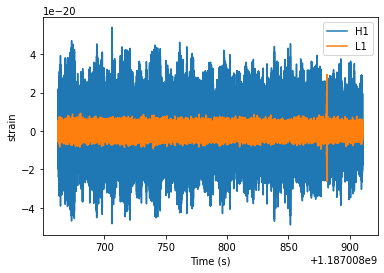

In [22]:
# here we can print our captured signal
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()


In [6]:
print(td_approximants())

['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'IMRPhenomTP', 'IMRPhenomTPHM', 'TaylorF2', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBN

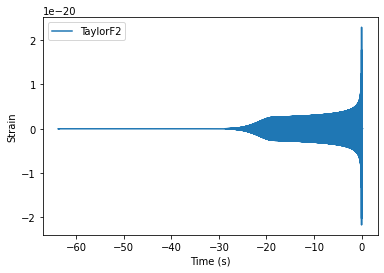

In [7]:
# This is how we create waveform templates to match with the data, we are using TaylorF2 waveform and working in frequancy domain
for apx in ['TaylorF2']:
    hp, hc = get_td_waveform(approximant=apx,
                                 mass1=1,
                                 mass2=3,
                                 delta_t=1.0/2048,
                                 f_lower=40)

    pylab.plot(hp.sample_times, hp, label=apx)

pylab.ylabel('Strain')
pylab.xlabel('Time (s)')

pylab.legend()
pylab.show()


- Write down the code to calculate the matched filter between the given data and a template waveform. After that, find out the template waveform for which the signal to noise ratio is maximum. For simplicity, you can assume the template waveform is produced from an equal mass binary system. Produce a plot which shows the SNR versus total mass of the system, where masses of the systems are uniformly distributed in a range 1M ≤ m1,2 ≤ 3M (use m1 = m2). Represent the result by fitting the best match template waveform against the data. Also, show the chirp structure of the signal over the time-frequency domain using Q-transformation().
- Here, we would like to investigate the correlation in the parameter space of gravita- tional waves from compact binary coalescences. Let us consider a gravitational wave h∗(t; m1,m2) generated from a binary with masses m1 = m2 = 10M . Now, we want to understand how the nearby templates are correlated with that waveform. Calculate the match between h∗(t; m1,m2) and the nearby templates that are generated assum- ing 5M ≤ m1,m2 ≤ 15M . Of course, one should have the maximum match (= 1) when hi = h∗. You will see that the match between two nearby waveforms is not zero. So, one can realize the gravitational waveforms are correlated for two nearby points in the parameter space. This fact is used to produce a template bank for detecting gravitational waves.

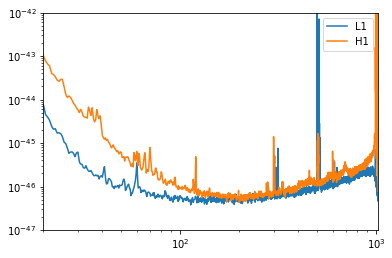

In [23]:
# We calculate the power spectral density function for both detectors

psds = {}
for ifo in ['L1', 'H1']:

    delta_t = strain[ifo].delta_t
    seg_len = int(2 / delta_t)
    seg_stride = int(seg_len / 2)
    psds[ifo]  = pycbc.psd.welch(strain[ifo],
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()

In [24]:
psds[ifo].delta_f

0.004032258064516129

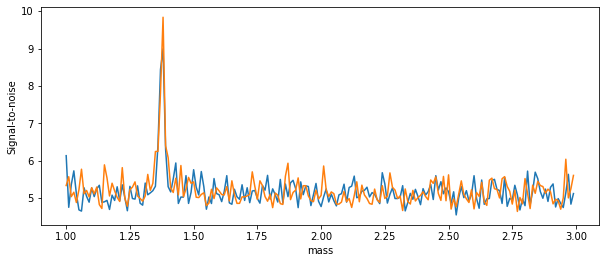

In [33]:
# Here we are going to plot the signal to noise ratio to find the maximum, then we can estimate what masses 
# the binary system consists of by matching the filter with a test waveform to data.

mass1 = np.arange(1, 3, 0.01) # mass range bewteen 1 and 3 Solar mass
mass2 = mass1

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = {}

# Working with detector H1:
ifo = 'H1'
Snr_list = [] # create an emtry array
for i in range(len(mass1)): # create a wavefunction that iterates over the masses and finds the waveform
    m = mass1[i] # Solar masses
    hp, hc = get_fd_waveform(approximant="TaylorF2",  #Generate a waveform with a given component mass; assumed equal mass, nonspinning
                     mass1=m,
                     mass2=m,
                     delta_f=stilde[ifo].delta_f,
                     f_lower=20.0)
    # We resize the vector to match with the data
    hp.resize(len(stilde[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, stilde[ifo],
                     psd=psds[ifo], low_frequency_cutoff=20.0) # apply the filter

    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seonds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.

    snr_H1 = snr.crop(4 + 4, 4)

    Snr_list.append(max(abs(snr_H1)))
snrs_H1 = Snr_list

# Working with detector L1: same process as before
ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
    m = mass1[i] # Solar masses
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                     mass1=m,
                     mass2=m,
                     delta_f=stilde[ifo].delta_f,
                     f_lower=20.0)
    
    hp.resize(len(stilde[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, stilde[ifo],
                     psd=psds[ifo], low_frequency_cutoff=20.0)
    
    snr_L1 = snr.crop(4 + 4, 4)

    Snr_list.append(max(abs(snr_L1)))
snrs_L1 = Snr_list
mmax = m

#we append or matched data to the snr list

In [ ]:
# Plot the signal-to-noise ratio
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs_H1, label= ifo)
pylab.plot(mass1, snrs_L1, label= ifo)
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mmax)
pylab.show()

In [17]:
"""
# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0
snrs = []

for m in mass1:
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
    hp, hc = get_fd_waveform(approximant="TaylorF2", 
                             mass1=m, mass2=m, 
                             f_lower=20, delta_f=stilde[ifo].delta_f)
    hp.resize(len(stilde[ifo]))
    
    # Matched filter the data and find the peak  
    max_snr, max_time = {}, {}
    for ifo in ['L1', 'H1']:
        snr = matched_filter(hp, stilde[ifo], psd=psds[ifo], low_frequency_cutoff=20.0)

        # The complex SNR at the peak
        snr = snr.time_slice(merger.time - 1, merger.time + 1)
        _, idx = snr.abs_max_loc()
        max_snr[ifo] = snr[idx]
        
        # The time of the peak
        max_time[ifo] = float(idx) / snr.sample_rate + snr.start_time
    
    network_snr = (abs(np.array(list(max_snr.values()))) ** 2.0).sum() ** 0.5
    snrs.append(max_snr)
    
    # Keep track of only the loudest peak
    if network_snr > nsnr:
        tmax, hmax, mmax, smax = max_time, hp, m, max_snr
        nsnr = network_snr

# See the SNR as a function of the component mass. Notice where this peaks as it gives us
# an estimate of what the parameters of the source system are. Note that masses
# here are in the *detector* frame, so if the source is located far away, it will in
# fact correspond to a lighter system due to cosmological redshift.
print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mmax)


We found the best Mass1=Mass2 was 1.38 solar masses (detector frame)


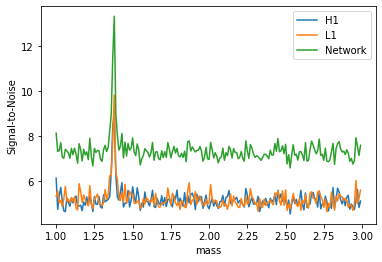

We found the best Mass1=Mass2 was 1.38 solar masses (detector frame)


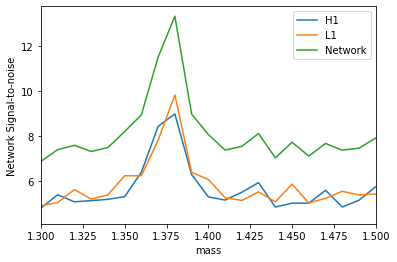

In [34]:
nsnr = (np.array(snrs_H1)**2 + np.array(snrs_L1)**2)**0.5
ii = np.where(nsnr == max(nsnr))
pylab.plot(mass1, snrs_H1, label= 'H1')
pylab.plot(mass1, snrs_L1, label= 'L1')
pylab.plot(mass1, nsnr, label='Network')
pylab.legend()

pylab.ylabel('Signal-to-Noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

pylab.figure()
pylab.xlim(1.3, 1.5)
pylab.plot(mass1, snrs_H1, label= 'H1')
pylab.plot(mass1, snrs_L1, label= 'L1')
pylab.plot(mass1, nsnr, label='Network')
pylab.legend()

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

In [35]:
"""
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend()
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

KeyError: ignored

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


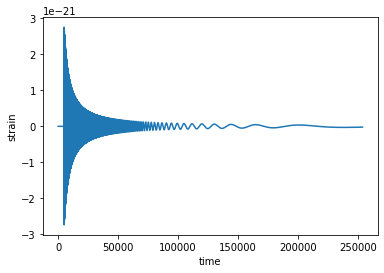

In [36]:
m=1.38
conditioned = stilde['H1']
hp, hc = get_fd_waveform(approximant="TaylorF2",
                     mass1 = 1.38,
                     mass2 = 1.38,
                     delta_f = conditioned.delta_f,
                     f_lower = 20.0)

# We will resize the vector to match our data
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

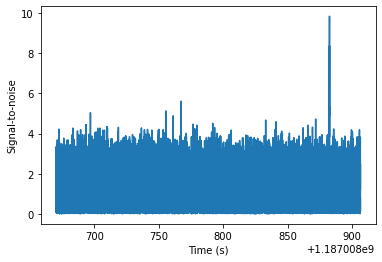

We found a signal at 1187008882.425879s with SNR 9.836596697567762


In [37]:

ifo = 'L1'                            
conditioned = stilde[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = np.argmax(abs(snr))
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, abs(snrp)))


In [38]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * float(snrp)).to_timeseries()
aligned.start_time = conditioned.start_time

<ipython-input-38-131e9d2ec36c>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  aligned = (aligned.to_frequencyseries() * float(snrp)).to_timeseries()


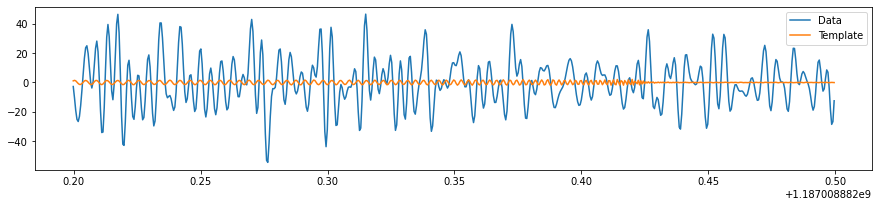

In [39]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
#white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

In [ ]:
print(type(dt))

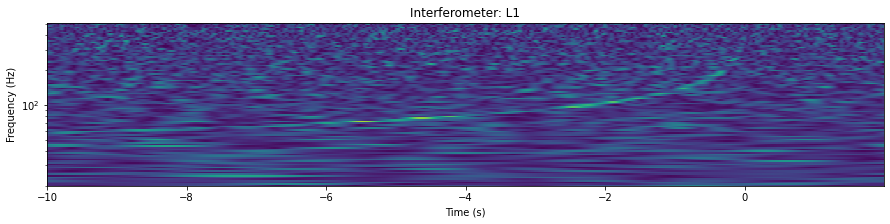

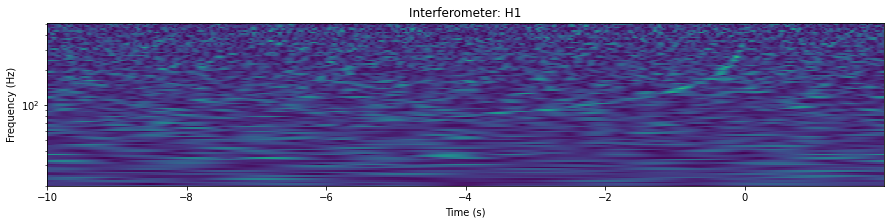

In [40]:
for ifo in ['L1', 'H1']:
    # Whiten the data
    hoft = (stilde[ifo] / psds[ifo] ** 0.5).to_timeseries()

    # Select the time around the event
    zoom = hoft.time_slice(merger.time - 10, merger.time + 2)

    # Calculate the qtransform (a kind of time-frequency representation similar to a spectrogram)
    times, freqs, power = zoom.qtransform(.01, logfsteps=100, frange=(20, 512), qrange=(110, 110))

    pylab.figure(figsize=(15,3))
    pylab.pcolormesh(times - merger.time, freqs, power**0.5, vmin=0, vmax=6)
    pylab.ylim(20, 512)
    pylab.title('Interferometer: %s' % ifo)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.yscale('log')

In [41]:
"""
for ifo in ['L1', 'H1']:
    # Shift the template to the maximum time at this sample rate
    dt =  tmax[ifo] - stilde[ifo].start_time
    inj = hmax.cyclic_time_shift(dt)

    # Scale the template to the SNR and phase we measured above
    inj /= sigma(hmax, psd=psds[ifo], low_frequency_cutoff=20.0) # This scales the template to unit SNR
    inj *= smax[ifo] # This scales the template to the SNR / phase we found

    # Subtract from the data
    stilde2 = stilde[ifo] - inj

    # Whiten the data
    hoft = (stilde2 / psds[ifo] ** 0.5).to_timeseries()

    # Select the time around the event
    zoom = hoft.time_slice(merger.time - 30, merger.time + 2)

    # Calculate the qtransform (a kind of time-frequency representation similar to a spectrogram)
    times, freqs, power = zoom.qtransform(.01, logfsteps=100, frange=(20, 512), qrange=(110, 110))

    pylab.figure(figsize=(15,3))
    pylab.pcolormesh(times - merger.time, freqs, power**0.5, vmin=0, vmax=6)
    pylab.ylim(20, 512)
    pylab.title('Interferometer: %s' % ifo)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.yscale('log')

# Note that a better match to the data can be found if you allow more
# freedom in the possible source parameters than we
# have here.

KeyError: ignored

Here, we would like to investigate the correlation in the parameter space of gravita- tional waves from compact binary coalescences. Let us consider a gravitational wave h∗(t; m1,m2) generated from a binary with masses m1 = m2 = 10M . Now, we want to understand how the nearby templates are correlated with that waveform. Calculate the match between h∗(t; m1,m2) and the nearby templates that are generated assum- ing 5M ≤ m1,m2 ≤ 15M . Of course, one should have the maximum match (= 1) when hi = h∗. You will see that the match between two nearby waveforms is not zero. So, one can realize the gravitational waveforms are correlated for two nearby points in the parameter space. This fact is used to produce a template bank for detecting gravitational waves.
[8]
0s


In [42]:
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import match
mass=10
ms=[]
f_low=30
sample_rate=4096
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=10,
                     mass2=10,
                     delta_t=1/sample_rate,
                     f_lower=30) #creating the first wave form
mass_range = np.arange(5, 15,0.2 )#They are not many, but in this way I can speed up a bit the process
sps=[]
for m in mass_range:
  sp, sc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=1/sample_rate,
                     f_lower=30)
  sps.append(sp)

data_len=max(len(hp),len(sps[0]))
hp.resize(data_len)
for sp in sps:
  sp.resize(data_len)
  delta_f=1.0/sp.duration
  flen=data_len//2+1
  psd=aLIGOZeroDetHighPower(flen,delta_f,f_low)
  m,i=match(hp,sp,psd=psd,low_frequency_cutoff=f_low)
  ms.append(m)


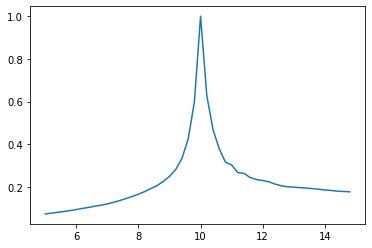

In [43]:
pylab.plot(mass_range, ms);

In [44]:
"""
f_low = 30
sample_rate = 4096
comp_value = []
masses = np.arange(5, 15, 0.05) #mass range bewteen 30 to 40 Solar mass

# Generate the two waveforms to compare 
hp, hc = get_fd_waveform(approximant = "TaylorF2",
                           mass1 = 10,
                           mass2 = 10,
                           f_lower = f_low,
                           delta_f = 1.0/sample_rate)

for m in masses:
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
    sp, sc = get_td_waveform(approximant="TaylorT2",
                     mass1 = m,
                     mass2 = m,
                     delta_t = 1/sample_rate,
                     f_lower = 30)
    comp_value.append(sp)

# Resize the waveforms to the same length 
tlen=max(len(hp),len(comp_value[0]))
sp.resize(tlen)
hp.resize(tlen)
m_val=[]
for i in comp_value:
  i.resize(tlen)
# Generate the aLIGO ZDHP PSD 
for j in comp_value:
  delta_f = 1.0 / sp.duration
  flen = tlen//2+1
  psd = aLIGOZeroDetHighPower(flen, delta_f, f_low) 
  m,i = match(hp, j, psd = psd, low_frequency_cutoff = f_low)
  m_val.append(m)



ValueError: ignored